In [2]:
from PIL import Image
import numpy as np
from CaptionGenerator import CaptionGenerator
import os
import dotenv
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torch 


print("Loading caption generator")
dotenv.load_dotenv(".env", override=True)
openai_key =  os.getenv("OPENAI_API_KEY")
device = 'cuda:0'

cg = CaptionGenerator(openai_key, device, verbose=True, filter=False, topk=50, gpt4=True)


/home/andre/anaconda3/envs/caption/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading caption generator
CaptionGenerator VERBOSE
Filtering TRUE
Topk 50
Device cuda:0
Using GPT4
cuda:0
cuda:0


In [3]:
with open('img_paths.txt', 'r') as f: 
    img_paths = f.readlines()
    img_paths = [x.strip() for x in img_paths]
# np.random.shuffle(img_paths)
img_paths = img_paths


def get_img(img_path):
    image = Image.open(img_path)
    image = image.resize((512, 512))
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    return image


In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/andre/autocaptioning-modelception/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

def load_sa():
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    return predictor

predictor = load_sa()

In [61]:
from diffusers import StableDiffusionInpaintPipeline

def load_diffusion():
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        # "runwayml/stable-diffusion-inpainting",
        "stabilityai/stable-diffusion-2-inpainting",
        revision="fp16",
        torch_dtype=torch.float16,
    ).to(device)
    return pipe

pipe = load_diffusion()

/home/andre/anaconda3/envs/caption/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [5]:
def generate_bboxes(image):
    count, bboxes, text_labels = cg.get_objects(image)
    return bboxes, text_labels, count

from PIL import ImageFont 
fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
def draw_bounding_boxes(image, bboxes, labels, captions):
    # dont draw on original image
    image = image.copy()
    draw = ImageDraw.Draw(image)
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        # write label in big font
        draw.text((x1, y1), labels[i], font=fnt, fill="yellow")
    return image

def bilinear_interpolation(x, y, q11, q12, q22, q21):
    return q11 * (1 - x) * (1 - y) + \
           q21 * x * (1 - y) + \
           q12 * (1 - x) * y + \
           q22 * x * y




In [6]:
import os
path = './images'
img_paths = [p for p in os.listdir(path) if p.endswith('.jpg')]
img_names = [p.split('.')[0] for p in img_paths]

segmentations = {}
for imgn in img_names:
    seg = {}
    seg['image'] = np.load(f'{path}/{imgn}_image.npy')
    seg['mask'] = np.load(f'{path}/{imgn}_mask.npy')
    seg['bbox'] = np.load(f'{path}/{imgn}_bbox.npy')
    segmentations[imgn] = seg

segmentations.keys()

dict_keys(['carrot3', 'pan3', 'pan1', 'red_plate3', 'red_plate2', 'ketchup2', 'bellpepper_in_bowl2', 'bellpepper_in_bowl1', 'carrot2', 'bellpepper1', 'red_plate1', 'ketcup3', 'bg', 'ketchup1', 'bowl2', 'bellpepper3', 'bowl1', 'pan2', 'carrot1', 'bellpepper2'])

In [14]:
segmentations['carrot1']['bbox']

array([208.17913818, 201.61715698, 415.79492188, 314.39144897])

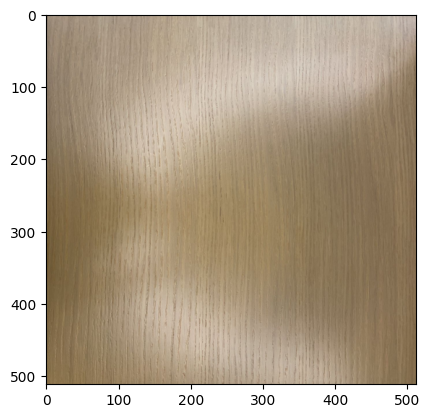

In [13]:
bg = np.load('./images/bg_image.npy')
vertices = np.array([[50, 50], [512-50, 50], [512-50, 512-50], [50, 512-50]])
plt.imshow(bg)

(1, 1) ['red_plate']
(2, 2) ['carrot']
(2, 3) ['ketchup']
(3, 1) ['pan']


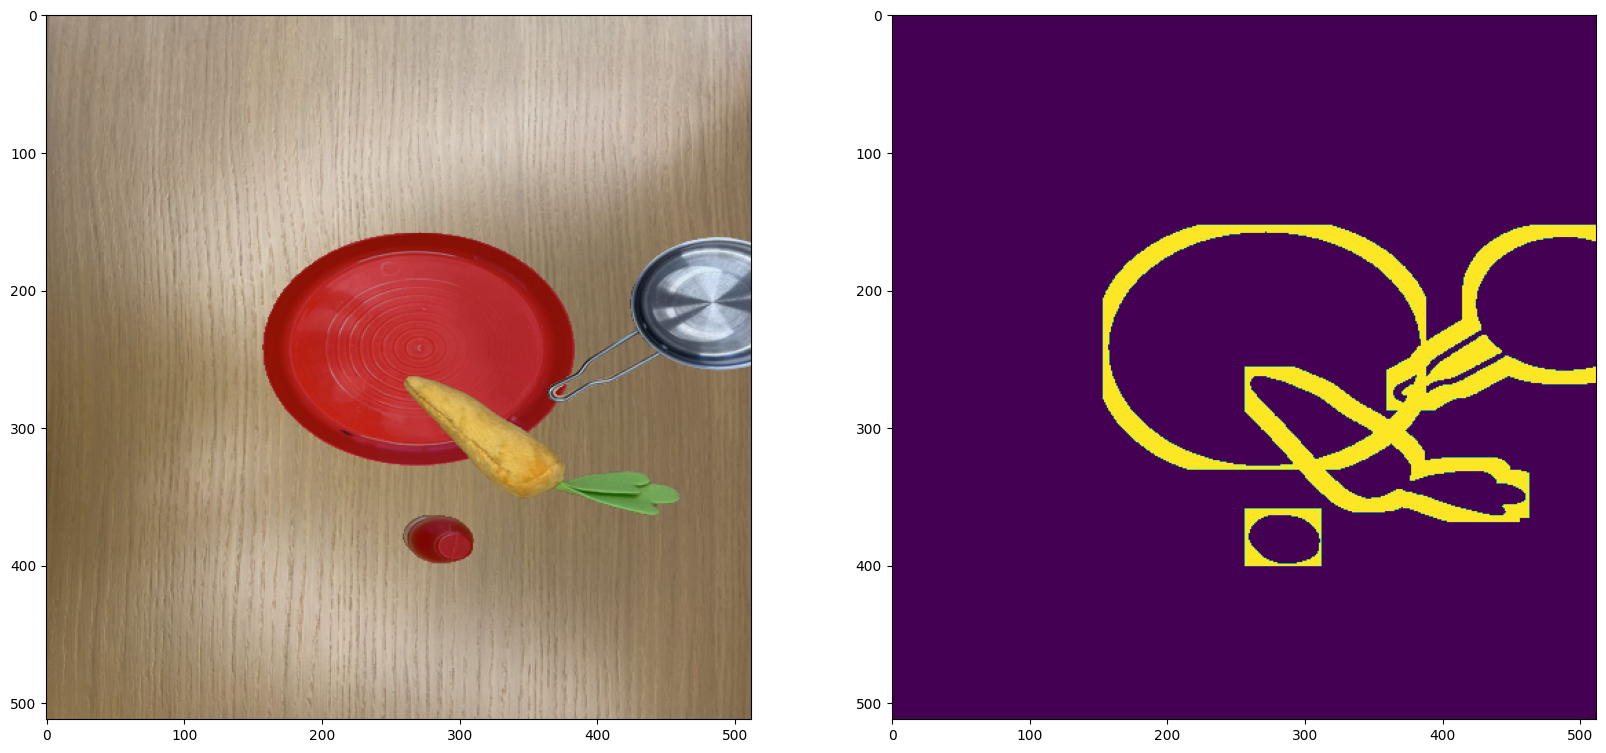

In [64]:
def get_crop(img, bbox):
    crop = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    return crop 

import numpy as np

def paste_array(A, B, B_mask, x, y):
    """
    Paste 2D NumPy array B into another array A, centered at integer coordinates x, y.
    Handle the case where B can go over the edges of A.
    """
    A = A.copy()

    s = max(B.shape[0], B.shape[1])
    A = np.pad(A, s, mode='constant', constant_values=0)[:, :, s:-s]
    x, y = x + s, y + s

    B_mask = B_mask[:, :, np.newaxis]
    A[x:x+B.shape[0], y:y+B.shape[1]] *= 1 - B_mask
    A[x:x+B.shape[0], y:y+B.shape[1]] += B * B_mask
    A = A[s:-s, s:-s]

    return A

def paste_mask(A, B, x, y):
    """
    Paste 2D NumPy array B into another array A, centered at integer coordinates x, y.
    Handle the case where B can go over the edges of A.
    """
    A = A.copy()

    s = max(B.shape[0], B.shape[1])
    A = np.pad(A, s, mode='constant', constant_values=0)
    x, y = x + s, y + s

    A[x:x+B.shape[0], y:y+B.shape[1]] += B
    A = A[s:-s, s:-s]
    A = np.clip(A, 0, 1)

    return A

grid_size = [4, 4]
state = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]
state[1][1].append('red_plate')
state[3][1].append('pan')
state[2][3].append('ketchup')
state[2][2].append('carrot')

import cv2
kernel = np.ones((3,3),np.uint8)

inpainting_mask = np.zeros((512, 512))
image = bg.copy()
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        if len(state[i][j]) > 0:
            print(f'({i}, {j})', state[i][j])

            for k in range(len(state[i][j])):
                obj_name = state[i][j][k]
                choices = [k for k in segmentations.keys() if obj_name in k]
                seg = segmentations[np.random.choice(choices)]
                bbox = seg['bbox']
                mask = seg['mask'].astype(np.uint8)
                obj = seg['image']
                dilated_mask = cv2.dilate(mask, kernel, iterations=10)
                obj_edge = dilated_mask - mask
                
                mask_crop = get_crop(mask, bbox)
                obj_edge_crop = get_crop(obj_edge, bbox)
                obj_crop = get_crop(obj, bbox)

                cx, cy = bilinear_interpolation(i/grid_size[0], j/grid_size[1], *vertices)
                cx, cy = int(cx), int(cy)
                image = paste_array(image, obj_crop, mask_crop, cx, cy)

                inpainting_mask = paste_mask(inpainting_mask, obj_edge_crop, cx, cy)

# plot img and mask side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[1].imshow(inpainting_mask)



100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


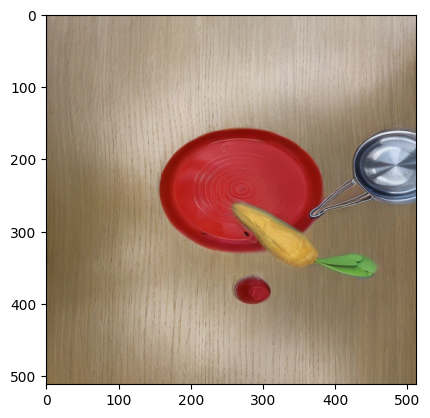

In [65]:
# pipe = load_diffusion()
output = pipe(prompt="",
            image=image,
            mask_image=inpainting_mask,).images[0]
plt.imshow(output)

In [16]:
# cg.set_words(['mechanical arm', 'bowl', 'spoon', 'knife', 'spatula', 
                # 'sink', 'plate', 'towel', 'stove', 'fork', 'pepper', 'table'])
# cg.set_words(['bowl', 'spoon', 'knife', 'spatula', 
                # 'sink', 'towel', 'stove', 'fork', 'pepper'])

# cg.set_words(['table'])
# objects = {}

# random_order = np.random.permutation(len(img_paths))
# for k in random_order[:10]:
#     img = get_img(img_paths[k])
#     bboxes, labels, count = generate_bboxes(img)

#     bimg = draw_bounding_boxes(img, bboxes, labels, None)
#     # plt.imshow(img)

#     npimg = np.array(img)
#     predictor.set_image(npimg)

#     def get_crop(img, bbox):
#         crop = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
#         return crop 

#     # show images side by side
#     # fig, ax = plt.subplots(2, 5, figsize=(10, 10))
#     for i, (bbox, label) in enumerate(zip(bboxes, labels)):
#         input_box = np.array(bbox)
#         print('segmenting for ' + label)
#         masks, _, _ = predictor.predict(
#             point_coords=None,
#             point_labels=None,
#             box=input_box[None, :],
#             multimask_output=False,
#         )
#         mask = masks[0]
#         print(bbox)
#         cropped_img = get_crop(npimg, bbox)
#         cropped_mask = get_crop(masks[0], bbox)
#         segmented = cropped_img * cropped_mask[..., None]
#         print(segmented.shape)

#         if label not in objects:
#             objects[label] = []
#         objects[label].append(segmented)
#         # ax[i//5][i%5].imshow(segmented)

# # ax[1][4].imshow(bimg)
print(objects.keys())
for key in objects:
    print(len(objects[key]))
# fig, ax = plt.subplots(2, 5, figsize=(10, 10))
# for j,img in enumerate(objects['fork']):
#     ax[j//5][j%5].imshow(img)

dict_keys(['towel', 'sink', 'bowl', 'pepper', 'spatula', 'knife', 'fork', 'spoon'])
12
7
7
6
7
7
4
4


In [56]:
key = 'pepper'
i = 6

img = objects[key][i]
plt.imshow(img)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 key = 'pepper'                                                                               │
│   2 i = 6                                                                                        │
│   3                                                                                              │
│ ❱ 4 img = objects[key][i]                                                                        │
│   5 plt.imshow(img)                                                                              │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

In [40]:
np.save(f'obj_images/{key}_{i}.npy', img)

In [46]:
# good = {}
# good['bowl'] = [objects['bowl'][_] for _ in [0, 4, 6, 8]]
# good['towel'] = [objects['towel'][_] for _ in [0, 1, 2, 3, 9]]
# good['spoon'] = [objects['spoon'][_] for _ in [0, 3, 4]]

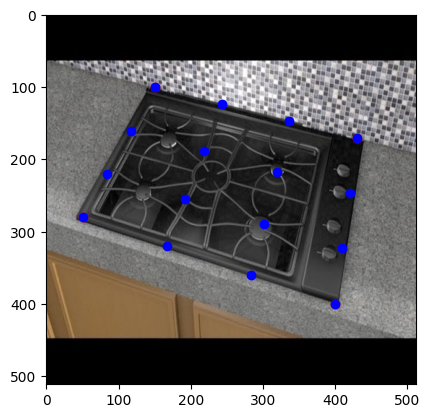

In [6]:
# k= 122
# img = get_img(img_paths[k])
img = get_img('/home/andre/autocaptioning-modelception/sddefault.jpg')
# plt.imshow(img)
bg = img
# save image
# img.save('test.png')
import numpy as np

vertices = np.array([(150, 100), (430, 170), (400, 400), (50, 280)])
# print(vertices)

plt.imshow(bg)
for v in vertices:
    plt.scatter(*v, c='r')


gd = 4j
gdr = int(gd.imag)
unit_grid = np.mgrid[0:1:gd, 0:1:gd].transpose((1, 2, 0))



# A, v0 = make_projection(vertices)
for i in range(gdr):
    for j in range(gdr):
        u = unit_grid[i, j]
        v = bilinear_interpolation(u[0], u[1], *vertices)
        plt.scatter(*v, c='b')
# u = np.array([1, 0])
# v= A @ u + v0
# plt.scatter(*v, c='b')

# v = bilinear_interpolation(0, 1, *vertices)
# plt.scatter(*v, c='b')

# us = [[0, 0], [1, 0], [1, 1], [0, 1]]
# vs = [map_point_to_quad(u[0], u[1], vertices) for u in us]
# print(vs)
# for v in vs:
#     plt.scatter(*v, c='b'


plt.show()

bg shape:  (1024, 1024, 3)
center coords:  [499 379]
obj size:  (110, 115, 3)
center coords:  [557 544]
obj size:  (26, 71, 3)
center coords:  [422 576]
obj size:  (131, 80, 3)


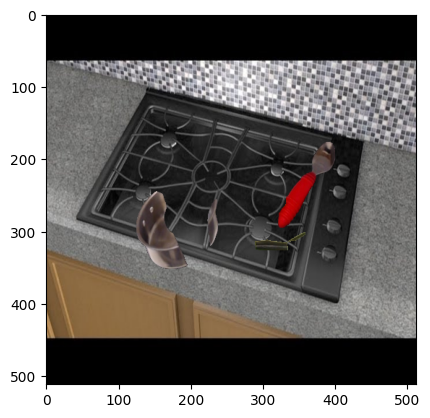

In [15]:
import cv2
def paste_obj(objects, coords, bg):
    bg = bg.copy()
    bg = np.array(bg)
    bg_ = np.zeros((1024, 1024, 3))
    bg_[256:256+bg.shape[0], 256:256+bg.shape[1]] = bg
    bg = bg_
    # plt.imshow(bg)
    print('bg shape: ', bg.shape)
    total_mask = np.zeros(bg.shape[:2], dtype=bool)
    for obj, coord in zip(objects, coords):
        coord = np.array(coord).astype(int)
        coord = coord + 256
        # print(coord)
        print('center coords: ', coord)
        print('obj size: ', obj.shape)

        obj_mask = obj.sum(axis=2) > 0
        
        bg[coord[0]:coord[0]+obj.shape[0], coord[1]:coord[1]+obj.shape[1]][obj_mask] = obj[obj_mask]
        total_mask[coord[0]:coord[0]+obj.shape[0], coord[1]:coord[1]+obj.shape[1]] = total_mask[coord[1]:coord[1]+obj.shape[0], coord[0]:coord[0]+obj.shape[1]] | obj_mask
    
    kernel = np.ones((3,3),np.uint8)
    dilated_mask = total_mask.copy()
    dilated_mask = cv2.dilate(dilated_mask.astype(np.uint8),  kernel, iterations = 15)
    inpaint_mask = dilated_mask - total_mask

    return bg[256:-256, 256:-256].astype(np.uint8), total_mask[256:-256, 256:-256], inpaint_mask[256:-256, 256:-256]

objs = [objects['bowl'][4], objects['spatula'][2], objects['spoon'][3]]
coords = np.array([(0, 1/3), (2/3, 2/3), (3/3, 1/3)])
coords = [bilinear_interpolation(u[0], u[1], *vertices) for u in coords]

nbg, tm, inpm = paste_obj(objs, coords, bg)


# dilated_mask = cv2.dilate(tm.astype(np.uint8),  kernel, iterations = 15)

# plt.imshow(nbg.astype(int))
plt.imshow(nbg)

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


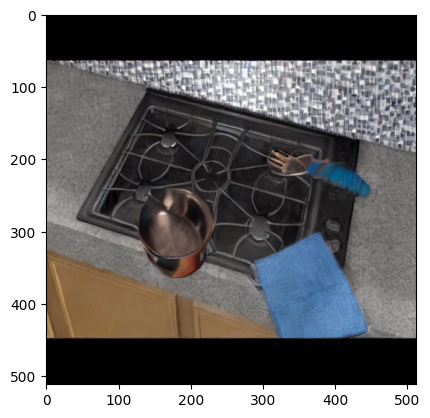

In [14]:
output = pipe(prompt="",
            image = nbg,
            mask_image = inpm).images[0]
plt.imshow(output)

100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


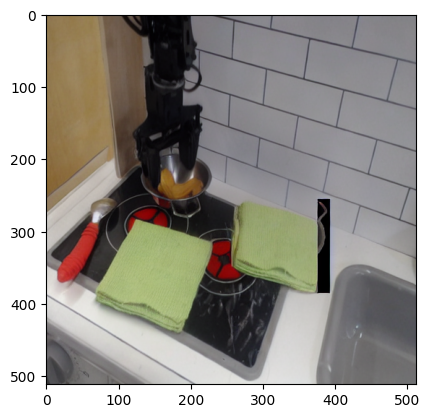

In [66]:
bg = np.array(bg)

obj = good['towel'][0]
obj_mask = (np.sum(obj, axis=2) > 0).astype(np.uint8)

kernel = np.ones((3,3),np.uint8)

# dilated_mask = cv2.dilate(obj_mask, kernel, iterations = 15)
offset = (256, 256)

bg[offset[0]:offset[0]+obj.shape[0], offset[1]:offset[1]+obj.shape[1]] = obj


inpainting_mask = np.ones_like(bg)[:, :, 0]
inpainting_mask[offset[0]:offset[0]+obj.shape[0], offset[1]:offset[1]+obj.shape[1]] = obj_mask


output = pipe(prompt="", 
            image=bg, 
            # mask_image=masks[0].astype(np.uint8),
            mask_image=1 - inpainting_mask.astype(np.uint8),
            ).images[0]
plt.imshow(output)

# plt.imshow(inpainting_mask)


In [ ]:
# pipeline
# object segmented objects from scenes
# generate initial + goal images using background + objects 

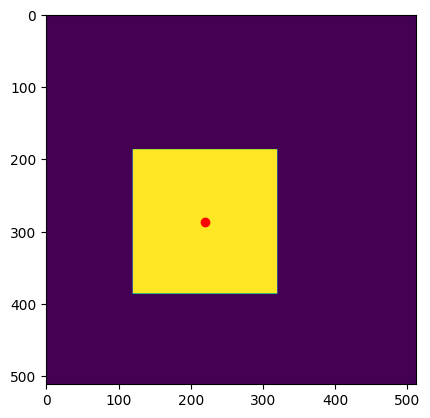

In [19]:
img = get_img('/home/andre/autocaptioning-modelception/test_images/bg.jpg')
img = np.array(img)

vertices = np.array([[170, 140], [10, 280], [300, 500], [400, 230]])

center = bilinear_interpolation(0.5, 0.5, *vertices)
center = center.astype(int)
plt.scatter(*center, c='r')

mask = np.zeros(img.shape[:2], dtype=bool)
# set a rectangle centered around center to be True
radius = 100
mask[center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius] = True

plt.imshow(mask)

100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


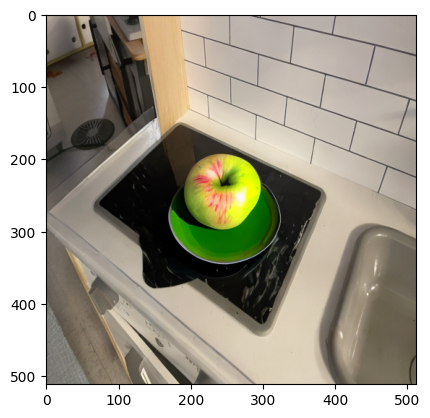

In [21]:

pipe = load_diffusion()
output = pipe(prompt="A large green plate with an apple in it, high resolution", 
            image=img, 
            # mask_image=masks[0].astype(np.uint8),
            mask_image=mask.astype(np.uint8),
            ).images[0]
plt.imshow(output)


In [7]:
del pipe

Getting objects


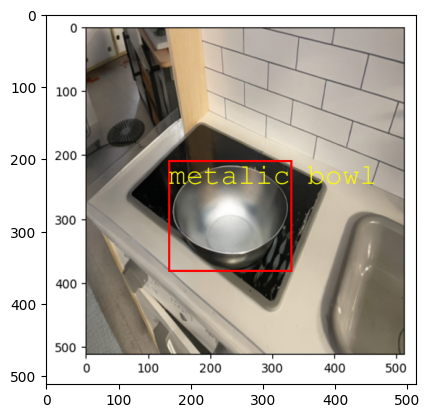

In [8]:
cg.set_words(['metalic bowl'])
img = get_img('/home/andre/autocaptioning-modelception/test_images/output.png')
bboxes, labels, count = generate_bboxes(img)
bimg = draw_bounding_boxes(img, bboxes, labels, None)

input_box = np.array(bboxes[0])
img = np.array(img)
predictor.set_image(img)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.imshow(bimg)

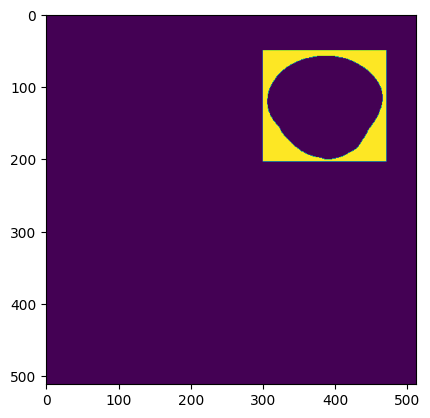

In [44]:
def get_crop(img, bbox):
    crop = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    return crop 

obj = img * masks[0][:, :, None]
obj_crop = get_crop(obj, input_box)
inpmc = (obj_crop.sum(axis=2) > 0).astype(np.uint8)
# inpainting_mask = 

# plt.imshow(inpmc)

bg = get_img('/home/andre/autocaptioning-modelception/test_images/bg.jpg')
bg = np.array(bg)

x, y = 50, 300
bg[x:x+obj_crop.shape[0], y:y+obj_crop.shape[1]] = obj_crop

inpm = np.zeros_like(bg[:, :, 0])
inpm[x:x+obj_crop.shape[0], y:y+obj_crop.shape[1]] = 1 - inpmc

plt.imshow(inpm)

100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


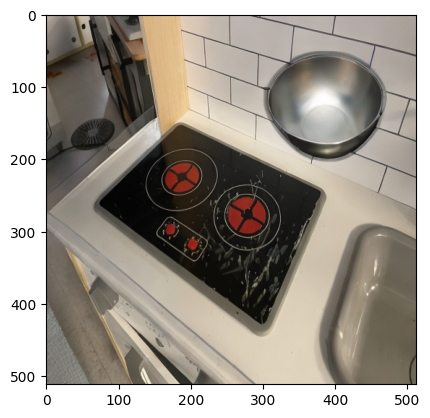

In [45]:
output = pipe(prompt="Metal bowl on the stove, high resolution",
            image=bg,
            mask_image=inpm.astype(np.uint8),).images[0]
plt.imshow(output)

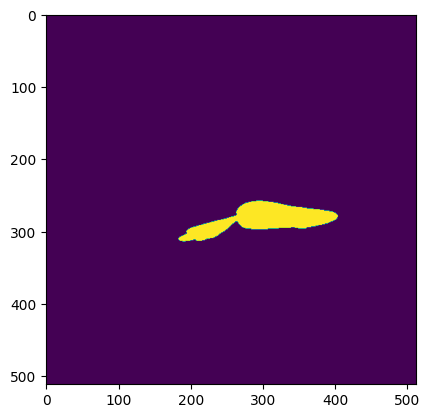

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
mask = np.load('./images/carrot3_mask.npy')
plt.imshow(mask)

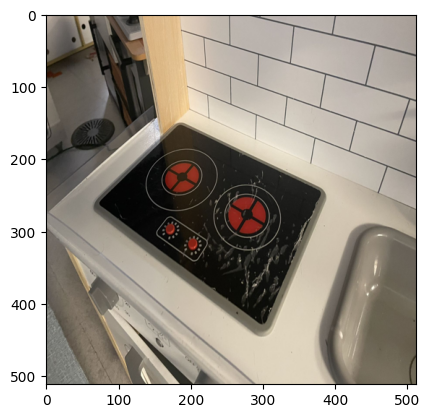

In [85]:
bg = get_img('/home/andre/autocaptioning-modelception/test_images/bg.jpg')
plt.imshow(bg)

100%|██████████| 50/50 [04:54<00:00,  5.90s/it]


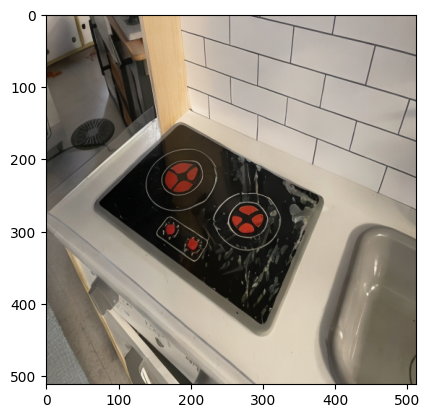

In [90]:
# plt.imshow(bg)
bg = np.array(bg)
mask = np.zeros_like(bg[:, :, 0])
mask[100:300, 200:400] = 1

# prompts= ["metallic bowl on table, top down view", "apple on table, top down view", "apple, top down view",
                        # "carrot, top down view", "apple"]

prompts = ['plate on table', 'orange on table', 'orange', 'apple on stove', 'apple']

outputs = pipe(prompt=prompts, 
            image=bg,
            num_inference_steps=50,
            mask_image=mask.astype(np.uint8),)
plt.imshow(outputs.images[0])

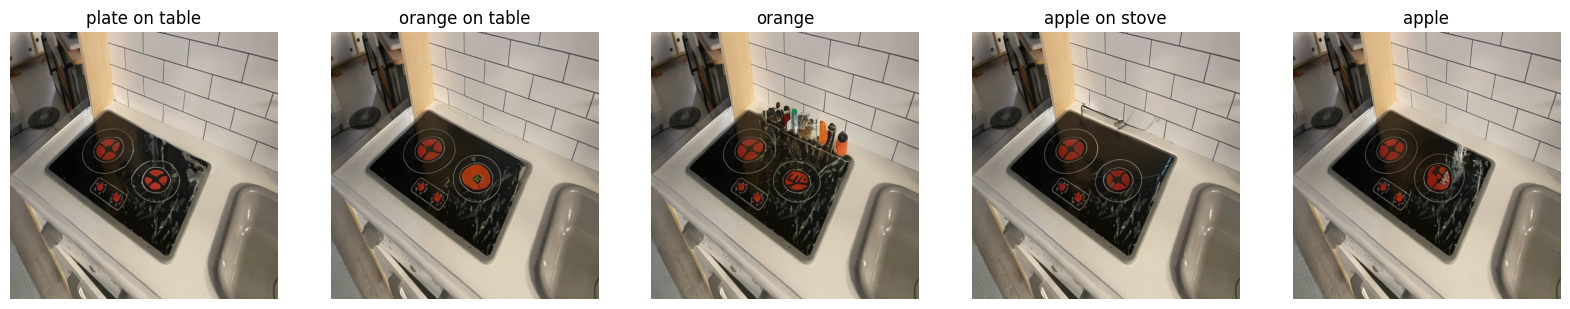

In [91]:
# show the images side by side
fig, axs = plt.subplots(1, len(outputs.images), figsize=(20, 20))
for i, ax in enumerate(axs):
    ax.imshow(outputs.images[i])
    ax.set_title(prompts[i])
    ax.axis('off')